#Mount Device#

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Imports#


In [ ]:
import pandas as pd
import csv
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt 

#Common Function Declarations#

In [34]:
# amount of songs in each period
def songs_per_period(df):
  value_count = df['period'].value_counts()
  print(value_count)
  print("Total sum: ", value_count.sum())

In [35]:
# accuracy score calculations
def scores(pred, test_class, n_labels=2 ):
  guess = [0 for i in range(n_labels)] 
  truth = [0 for i in range(n_labels)]

  for i in range(len(pred)):
    guess[pred[i]] += 1
    truth[test_class[i]] += 1
    
  print("Guess: ", guess)
  print("Truth: ", truth)
  print("Accuracy: ",metrics.accuracy_score(test_class,pred))

  cf_matrix = metrics.confusion_matrix(test_class, pred)
  if n_labels == 2:
    # tn, fp, 
    # fn, tp
    precision = cf_matrix[1][1] / (cf_matrix[0][1] + cf_matrix[1][1])
    print("Precision: ", precision)
    recall = cf_matrix[1][1] / (cf_matrix[1][0] + cf_matrix[1][1])
    print("Recall: ", recall)
    f1 = 2* precision * recall / (precision + recall)
    print("F1 Score: ", f1)

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [36]:
def tokenize(str):
  return str.split()

# **Period Classification**#

#Read preprocessed data#

In [37]:
csv_path = '/content/gdrive/MyDrive/machine learning/DATA/BALANCED.csv'
df = pd.read_csv(csv_path)

In [38]:
# shuffle df
df = df.sample(frac = 1)

In [ ]:
df.head()

,id,name,popularity,period,lyrics,pop_class
6462,72O7henR5rQfJWrbXafpYn,Assault and Battery / The Golden Void,33.0,70.0,life great men remind u may make life sublime ...,1
13958,7lG45eoR5vpSw7dLai0zp0,Fourth Of July,34.0,90.0,waiting get home work oh thing turn light cry ...,0
7071,2BsUqLbF2mlWl3skBBkJMG,Legends and Believe in the Day - Steven Wilson...,26.0,70.0,legend worded ancient tribal hymn lie cradled ...,0
11489,38Ngied9rBORlAbLYNCl4k,Once in a Lifetime - 2005 Remaster,70.0,80.0,may find living shotgun shack may find another...,1
21720,5oLWKwAejXRkOv8bKaTBO7,Turn The Music Up,55.0,10.0,red bull hand yeah feel like got wing lotta pe...,0


In [ ]:
songs_per_period(df)

70.0    4200
90.0    4200
80.0    4200
0.0     4200
60.0    4151
10.0    4126
Name: period, dtype: int64
Total sum:  25077


#Split data into train and test#

In [39]:
SIZE = df.shape[0]
SPLIT = int( SIZE*.80 )

In [40]:
# train data
df_train = df.iloc[0:SPLIT]
train_labels = df_train['period'].to_numpy()

songs_per_period(df_train)

70.0    3373
80.0    3370
0.0     3360
90.0    3337
60.0    3326
10.0    3295
Name: period, dtype: int64
Total sum:  20061


In [41]:
# test data
df_test = df.iloc[SPLIT: SIZE]
test_labels = df_test['period'].to_numpy()

songs_per_period(df_test)

90.0    863
0.0     840
10.0    831
80.0    830
70.0    827
60.0    825
Name: period, dtype: int64
Total sum:  5016


In [42]:
# transform the labels into classes
# using sklearn's label encoder
le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

train_class = le.transform(train_labels)
print(train_class)

test_class = le.transform(test_labels)
print(test_class)

[ 0. 10. 60. 70. 80. 90.]
[0 1 1 ... 1 3 1]
[3 0 0 ... 2 3 4]


In [56]:
# text vectorization with TF-IDF
lyrics = df['lyrics'].to_numpy()
vectorizer = TfidfVectorizer(tokenizer=tokenize)

In [57]:
# tested with ngram = (1,1), (1,2) and (1,3)
vectorizer.set_params(ngram_range=(1,3)) 

tfidf = vectorizer.fit_transform(lyrics)

In [58]:
tfidf_train = tfidf[0:SPLIT]
tfidf_test = tfidf[SPLIT: SIZE]

In [ ]:
print(tfidf_train)

In [59]:
tfidf_train.shape

(20061, 1387372)

# Predictions and results#

In [60]:
classifier = MultinomialNB()
naive = classifier.fit(tfidf_train, train_class)

In [61]:
pred = naive.predict(tfidf_test)
print(pred)

[0 1 0 ... 3 3 4]


Guess:  [804, 1386, 658, 827, 737, 604]
Truth:  [840, 831, 825, 827, 830, 863]
Accuracy:  0.39074960127591707


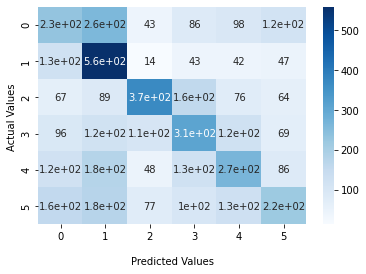

In [62]:
scores(pred, test_class, n_labels=6)

# **Popularity Classification**

# Read preprocessed data

In [ ]:
# Read data per period
dfs = []
for i in [60, 70, 80, 90, 0, 10]:
  filename = '/content/gdrive/MyDrive/machine learning/DATA/per_period/period_' + str(i) + '.csv'
  df = pd.read_csv(filename, index_col=0)
  # shuffle df
  df = df.sample(frac = 1)
  dfs.append(df)


In [ ]:
dfs

# Split Train and Test data

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tokenize)
vectorizer.set_params() 

TfidfVectorizer(tokenizer=<function tokenize at 0x7f06837cb5f0>)

In [ ]:
data_per_period = []
for df in dfs:
  lyrics = df['lyrics'].to_numpy() 
  tfidf = vectorizer.fit_transform(lyrics)

  split = int(df.shape[0] * .90)
  tfidf_train = tfidf[0:split]
  tfidf_test = tfidf[split: df.shape[0]]
  train_labels = df["pop_class"].iloc[0:split]
  test_labels = df["pop_class"].iloc[split: df.shape[0]]

  data = [tfidf_train, tfidf_test, train_labels, test_labels]
  data_per_period.append(data)
  

# Predictions and Results

In [ ]:
classifier = MultinomialNB()
periods = [60, 70, 80, 90, 0, 10]

For Period 60: 
Guess:  [399, 17]
Truth:  [263, 153]
Accuracy:  0.6442307692307693
Precision:  0.6470588235294118
Recall:  0.0718954248366013
F1 Score:  0.12941176470588234


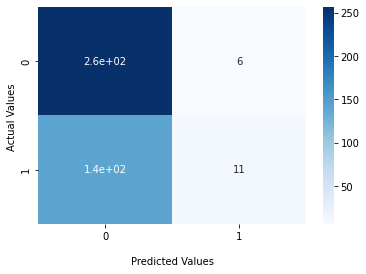

For Period 70: 
Guess:  [419, 1]
Truth:  [310, 110]
Accuracy:  0.7357142857142858
Precision:  0.0
Recall:  0.0
F1 Score:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


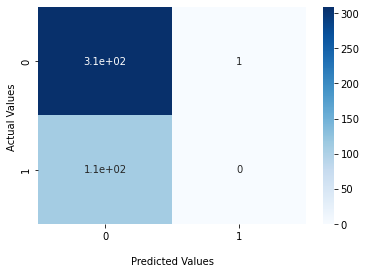

For Period 80: 
Guess:  [414, 6]
Truth:  [259, 161]
Accuracy:  0.6071428571428571
Precision:  0.16666666666666666
Recall:  0.006211180124223602
F1 Score:  0.011976047904191616


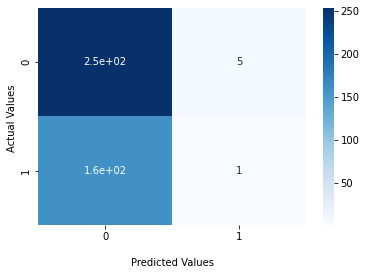

For Period 90: 
Guess:  [405, 15]
Truth:  [234, 186]
Accuracy:  0.5642857142857143
Precision:  0.6
Recall:  0.04838709677419355
F1 Score:  0.08955223880597016


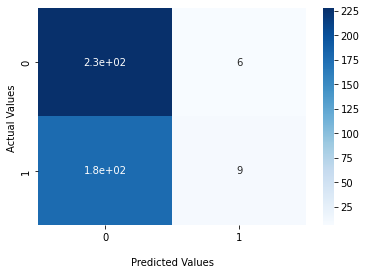

For Period 0: 
Guess:  [400, 20]
Truth:  [232, 188]
Accuracy:  0.5523809523809524
Precision:  0.5
Recall:  0.05319148936170213
F1 Score:  0.09615384615384615


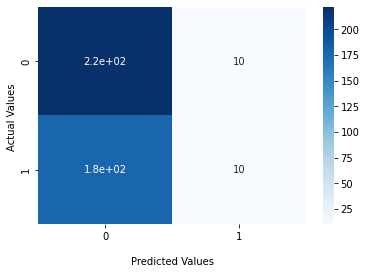

For Period 10: 
Guess:  [293, 120]
Truth:  [210, 203]
Accuracy:  0.6004842615012107
Precision:  0.6583333333333333
Recall:  0.3891625615763547
F1 Score:  0.4891640866873065


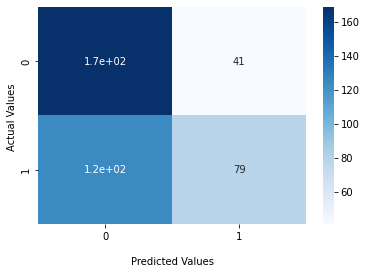

In [ ]:
for i in range(6):
  period = data_per_period[i]
  classifier.fit(period[0], period[2])
  pred = classifier.predict(period[1])

  print("For Period "+ str(periods[i]) + ": ")
  scores(pred, period[3],n_labels=2)

EXTRA

In [ ]:
# ONLY USE for report
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english') # to use bigrams ngram_range=(2,2)

lyric_list = df['lyrics'].to_numpy() 
Count_data = CountVec.fit_transform(lyric_list)

cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names()) 
print(cv_dataframe)

       00  000  007  00766  00p  01  ...  흘러  흘러도  희망을  힘겨운  힘없이  ﬂung
0       0    0    0      0    0   0  ...   0    0    0    0    0     0
1       0    0    0      0    0   0  ...   0    0    0    0    0     0
2       0    0    0      0    0   0  ...   0    0    0    0    0     0
3       0    0    0      0    0   0  ...   0    0    0    0    0     0
4       0    0    0      0    0   0  ...   0    0    0    0    0     0
...    ..  ...  ...    ...  ...  ..  ...  ..  ...  ...  ...  ...   ...
25072   0    0    0      0    0   0  ...   0    0    0    0    0     0
25073   0    0    0      0    0   0  ...   0    0    0    0    0     0
25074   0    0    0      0    0   0  ...   0    0    0    0    0     0
25075   0    0    0      0    0   0  ...   0    0    0    0    0     0
25076   0    0    0      0    0   0  ...   0    0    0    0    0     0

[25077 rows x 38395 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# one hot encoding
labels = df['period'].to_numpy()
one_hot_labels = [] 
for lab in labels: 
  lab_arr = [0, 0, 0, 0, 0, 0] 
#60, 70, 80, 90, 0, 10 
if lab > 50: 
  lab_arr[int((lab - 60) / 10)] = 1 
elif lab == 0: 
  lab_arr[4] = 1 
else: 
  lab_arr[5] = 1

one_hot_labels.append(lab_arr)

one_hot_labels = np.array(one_hot_labels) 
print(one_hot_labels[0])

[0 0 0 0 0 1]
